# Wykrywanie anomalii sieciowy &nbsp; | &nbsp; *Network Anomaly Detection*

## LAB 04 Autoenkodery (ae) &nbsp; | &nbsp; *Autoencoders (ae)*

- Autoenkodery &nbsp; | &nbsp; *Autoencoders*
- PCA  &nbsp; | &nbsp; *Principal component analysis (PCA)*


## Plan
|  | | |
| -------- | -------|---- |
| Wprowadzenie | *Introduction* | 15 min |
| Autoenkodery | *Autoencoders* |40 min |
| PCA | *PCA*  | 25 min |
| Podsumowanie | *Summary* | 10 min|

In [ ]:
#@title Required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() # set default styles for seaborn
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax

# Diamenty &nbsp; | &nbsp; *Diamonds*

Dalej pracujemy na danych o diamentach, ale bez etykiet

*We continue to work with the diamond dataset, but without considering the labels*


In [ ]:
#@title get data
!gdown  https://drive.google.com/uc?id=1c4-h7TLRaDmijstDIFD093to9uZwYA6F

Downloading...
From: https://drive.google.com/uc?id=1c4-h7TLRaDmijstDIFD093to9uZwYA6F
To: /content/diamonds.csv
100% 2.45M/2.45M [00:00<00:00, 59.5MB/s]


In [ ]:
diamonds = pd.read_csv('diamonds.csv')
display(diamonds.head())
x_raw = diamonds[['carat', 'x', 'y', 'z']] # select columns
print('\n\n selected: \n')
display(x_raw)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75




 selected: 



,carat,x,y,z
0,0.23,3.95,3.98,2.43
1,0.21,3.89,3.84,2.31
2,0.23,4.05,4.07,2.31
3,0.29,4.20,4.23,2.63
4,0.31,4.34,4.35,2.75
...,...,...,...,...
53935,0.72,5.75,5.76,3.50
53936,0.72,5.69,5.75,3.61
53937,0.70,5.66,5.68,3.56
53938,0.86,6.15,6.12,3.74


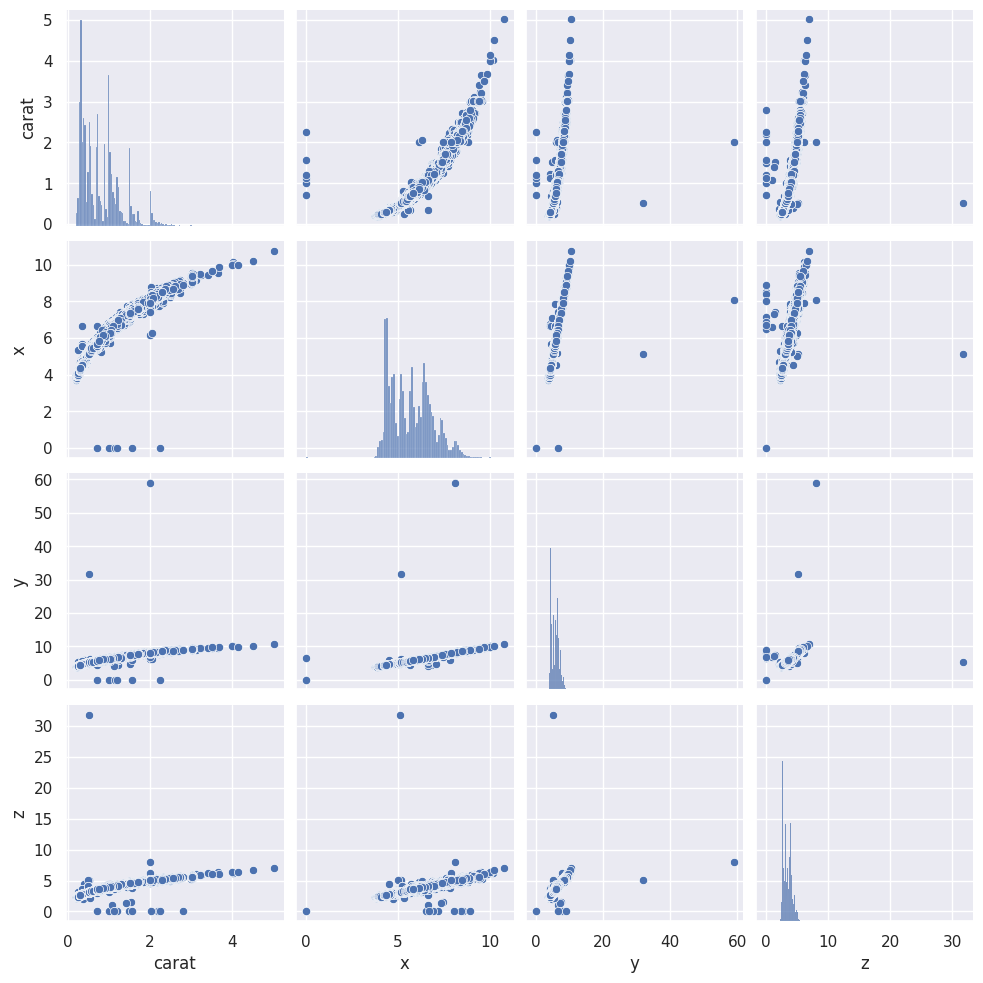

In [ ]:
sns.pairplot(x_raw);

In [ ]:
x = x_raw.to_numpy()
m = np.mean(x, 0)
display(m)
s = np.std(x, 0)
display(s)
x = (x-m)/s  # x ~N(0,1)
print(x.mean(axis=0))
print(x.std(axis=0))

array([0.79793975, 5.73115721, 5.73452595, 3.53873378])

array([0.47400685, 1.12175035, 1.14212409, 0.70569231])

[ 2.44487823e-16  2.78210281e-16 -8.43061459e-17 -2.00227096e-16]
[1. 1. 1. 1.]


# μ lib  &nbsp; | &nbsp; *micro library*




In [ ]:
def vector_mse(y,yhat):
    return jnp.mean(jnp.square(y-yhat), axis=-1) # axis=-1, last axis

# Autoenkoder  &nbsp; | &nbsp; *Autoencoder*

Autoenkoder to siec neuronowa prezybliżająca funkcję $f(x)=x$.

*An autoencoder is a neural network that approximates the function $f(x)=x$*

## Zadanie 1 | &nbsp; *Task 1*

Zbudować i wytrenować autoenkoder kompresujący `x,y,z,carat` do jednej liczby.

*Build and train an autoencoder that compresses `x,y,z,carat` to a single number.*

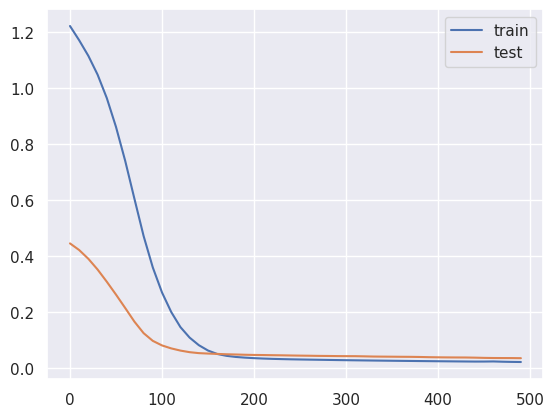

In [ ]:
batch_size = 128
steps = 500
learning_rate = 0.001
train_split = int(0.7*x.shape[0])

k = jax.random.PRNGKey(42) # random seed

encoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(1)
)

decoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(x.shape[1])
)

nn = stax.serial(encoder, decoder)

init_nn, apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)



@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      reconstruction = apply_nn(params,x)
      return jnp.mean(vector_mse(y,reconstruction))

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

@jax.jit
def test_loss(opt_state,x,y):
    params = get_params(opt_state)
    reconstruction = apply_nn(params,x)
    return jnp.mean(vector_mse(y,reconstruction))

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses = []
test_losses = []
train_steps = []

for i in range(steps):
    idx = np.random.randint(0, train_split, size=batch_size)
    bx = x[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,bx)

    if i % 10 == 0:
        tx = x[train_split:,...]
        test_losses.append(test_loss(opt_state,tx,tx))
        train_steps.append(i)
        losses.append(test_loss(opt_state,x[:train_split,...],x[:train_split,...]))

plt.plot(train_steps,losses,label='train')
plt.plot(train_steps,test_losses,label='test')

plt.legend()



## Zadanie 2  &nbsp; | &nbsp; *Task 2*

Narysować wykres rozrzutu rekonstrukcji danych.

*Draw a scatterplot of the data reconstruction.*

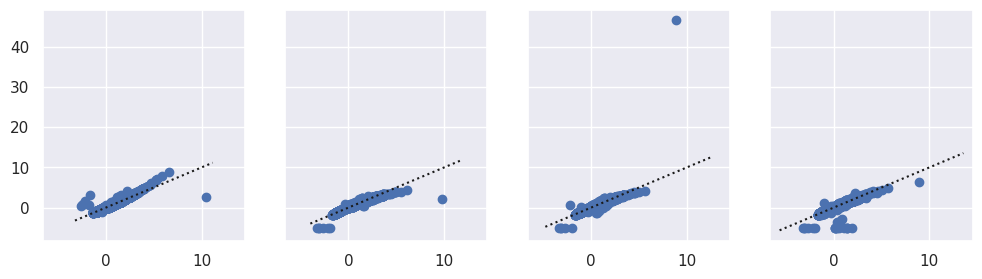

In [ ]:
rekonstrukcja = jax.jit(apply_nn)(get_params(opt_state),x[:train_split,...])
fig, axs = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=(12,3))

for i,ax in enumerate(axs):
    ax.scatter(rekonstrukcja[:,i],x[:train_split,i])
    ax.plot(ax.get_xlim(),ax.get_xlim(),'k:')

## Zadanie 3  &nbsp;| &nbsp; *Task 3*
Narysować histogram ukrytej reprezentacji

*Draw a histogram of the hidden representation*



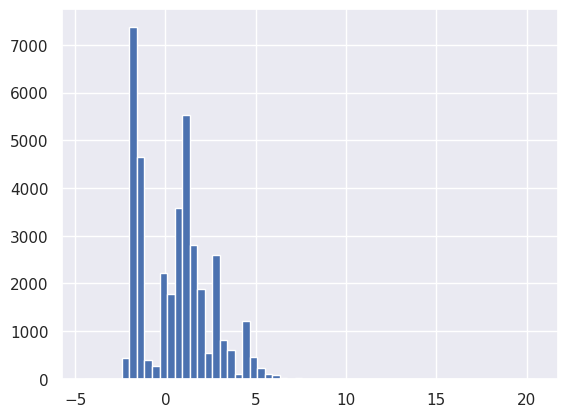

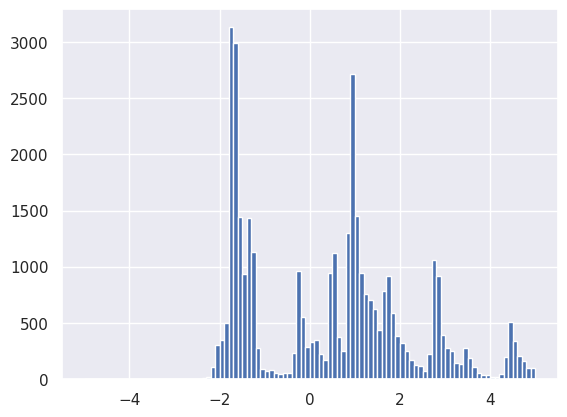

In [ ]:
encoder_params, decoder_params = get_params(opt_state)
z = encoder[1](encoder_params,x[:train_split,...])
plt.hist(np.asarray(z), bins=60);
plt.figure()
plt.hist(np.asarray(z), bins=100, range=(-5,5));

## Zadanie 4  &nbsp;| &nbsp; *Task 4*

1. Narysować histogram błędu rekonstrukcji na zbiorze testowym
 - *Plot a histogram of the reconstruction error on the test set*
2. Wprowadzić anomalie i ją wykryć
 - *Introduce anomalies and detect them*



In [ ]:
@jax.jit
def reconstruction_error(opt_state,x):
    params = get_params(opt_state)
    reconstruction = apply_nn(params,x)
    return vector_mse(x,reconstruction)

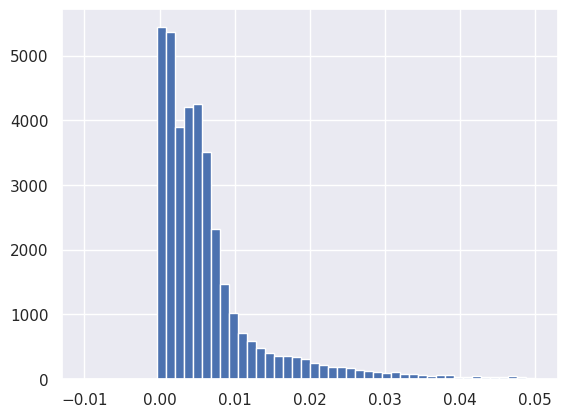

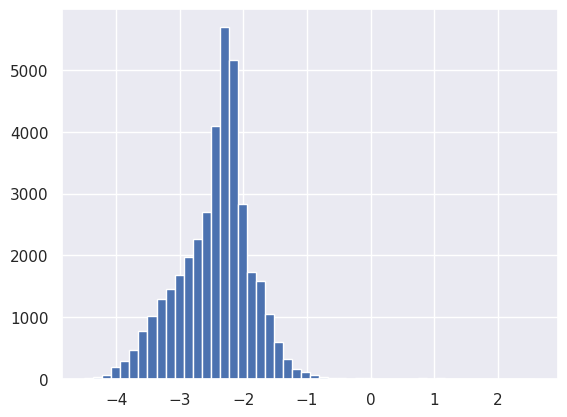

In [ ]:
errors = reconstruction_error(opt_state,x[:train_split,...])
plt.hist(errors,bins=50,range=(-0.01, 0.05))
plt.figure()
plt.hist(np.log10(errors),bins=50);

In [ ]:
xtmp = x[:train_split,...].copy()
# adding anomaly
print('original datum:', xtmp[100,2] )
xtmp[100,2] = 100* xtmp[100,2]
print('anomalous datum:', xtmp[100,2] )
errors = reconstruction_error(opt_state,xtmp)

q = np.quantile(errors,0.99)
anomalie, = np.where(errors>q)
print(len(anomalie))
assert 100 in anomalie # if 100 not in anomalie then error

original datum: 0.013548479899611962
anomalous datum: 1.3548479899611963
378


# PCA  &nbsp;| &nbsp; *Principal Component Analysis*

PCA to liniowy autoenkoder, dla którego wiemy, że macierz transformacji jest utworzona z wektorów własnych macierzy kowariancji.

*PCA can be considered as a linear autoencoder for which we know that the transformation matrix is ​​formed from the eigenvectors of the covariance matrix.*


In [ ]:
x = diamonds[['x','y','z']].to_numpy()
m = np.mean(x, 0)
s = np.std(x, 0)
x = (x-m)/s


## Zadanie 5  &nbsp;| &nbsp; *Task 5*
Wykonać PCA na danych `x,y,z`

*Perform PCA on 'x,y,z' data*


In [ ]:
print(x.shape)
cov_mat = np.cov(x.T)
print(cov_mat)
eig_val, eig_vec = np.linalg.eig(cov_mat)
idx_sort = np.flip(eig_val.argsort())
components = eig_vec[:,idx_sort]
print('eigenvect:')
display(components)
variances = eig_val[idx_sort]
print('eigenvalues:')
display(variances)

(53940, 3)
[[1.00001854 0.97471955 0.9707898 ]
 [0.97471955 1.00001854 0.95202337]
 [0.9707898  0.95202337 1.00001854]]
eigenvect:


array([[ 0.58008805, -0.0656425 ,  0.8119045 ],
       [ 0.57637161, -0.67124493, -0.46607511],
       [ 0.57558111,  0.73832331, -0.35154669]])

eigenvalues:


array([2.93174072, 0.04817818, 0.02013672])

In [ ]:
assert np.allclose(components@components.T, np.eye(3),rtol=1e-4,atol=1e-4) #@ is the matrix multiplication operator in numpy (np.matmul)
print(components@components.T)
print(np.eye(3))

[[ 1.00000000e+00  2.24273841e-15 -2.90159670e-15]
 [ 2.24273841e-15  1.00000000e+00  8.25756888e-16]
 [-2.90159670e-15  8.25756888e-16  1.00000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
z = x@components
print(z.shape)
print(np.var(z,0))
print(variances)
assert np.allclose(np.var(z,0), variances,rtol=1e-3,atol=1e-4)

(53940, 3)
[2.93168637 0.04817729 0.02013635]
[2.93174072 0.04817818 0.02013672]


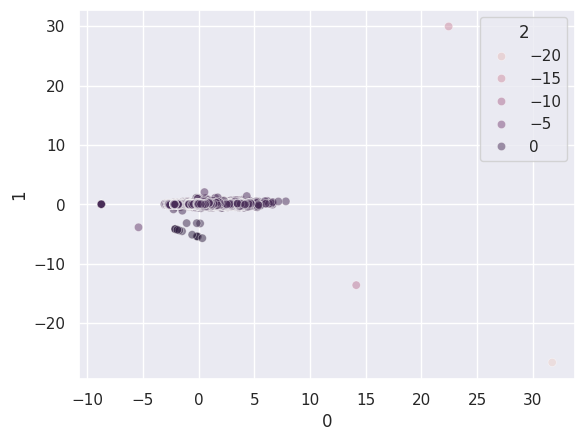

In [ ]:
sns.scatterplot(
    data= pd.DataFrame(z),
    x=0,
    y=1,
    hue=2,
    alpha=0.5
);

In [ ]:
@jax.jit
def pca(x):
    cov_mat = jnp.cov(x.T)
    eig_val, eig_vec = jnp.linalg.eig(cov_mat)
    idx_sort = np.flip(eig_val.argsort()) # <-- get ordering of eigenvectors: largest to smallest
    components = eig_vec[:,idx_sort]
    return jnp.real(components)


# Szybsza i stabilniejsza wersja PCA   &nbsp;| &nbsp; *Faster and more stable version of PCA*

https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

In [ ]:
u,s,vh = np.linalg.svd(x,full_matrices=False)
fi = vh.T
z = u@np.diag(s)

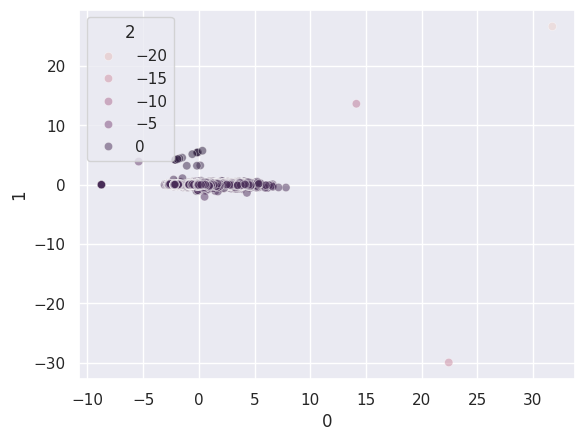

In [ ]:
sns.scatterplot(
    data= pd.DataFrame(z),
    x=0,
    y=1,
    hue=2,
    alpha=0.5
);